In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Basic expansion in base b

this code works for integers

In [2]:
def int2base(x, b=2):  
    digits = []
    while x > 0:
        digits.append(x % b)
        x //= b
    return list(reversed(digits))


In [765]:
def digits(p,q,
           b=2, num_digits=20):
    
    if (p > q): raise ValueError
    r = p
    digits = []
    for _ in range(num_digits):
        digits.append( (r*b) // q)
        r = (r*b) % q
    return digits

In [767]:
digits(1,6)

[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

---

## More sophistocated

This returns the **full** expansion in base ```b``` in 2 parts
1. an initial sequence of digits  which isn't repeated
1. the repeating part

---

### Examples

1/6 = 0.166666666

- starts with 1
- the repeating part is 6

$\frac16 = \frac{1}{10}  +  \frac{1}{10} \times \frac{6}{9}$ 

and form the binary expansion of $1/10$

- starts with 0
- the repeating part is 0011

$\frac{1}{10}   =  \frac{1}{2} \times  \left( 3  \times  \frac{1/16}{1- 1/16} \right)$ 

In [3]:
def digits(p,q,
           b=2,n=20):
    r = p
    pos = {p : 0}
    digits = []
    
    while True:
        p, r = (r*b) // q, (r*b) % q
        digits.append(p)
        # this is a trick
        if r in pos: break
        pos[r] = len(digits)
    
    return digits[:pos[r]], digits[pos[r]:]

In [4]:
digits(1,10,b=2)

([0], [0, 0, 1, 1])

In [307]:
digits(1,13,b=2)

([], [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1])

---

# Euler's constant


You should read the [wikipedia page](https://en.wikipedia.org/wiki/Euler%27s_constant)

I'll use **numpy** to do this without writing a ```for``` loop


In [5]:
np.arange(1,101)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

---

The ```for``` loop is to study the convergence over bigger and bigger ranges

Convergence is very very slow

-  because $1/n - (\log(n+1) -\log(n)) \rightarrow 0$ very slowly $O(1/n^2)$
- $2^{-n} \rightarrow 0$ much more quickly

In [6]:
[sum(1./np.arange(1,k)) - np.log(k) for k in range(1000,10000,1000)]

[0.5767155815682061,
 0.576965644068201,
 0.577048988975589,
 0.5770906596931713,
 0.5771156615681665,
 0.5771323292533648,
 0.5771442346293849,
 0.5771531635994176,
 0.577160108317134]

[euler's constant](https://en.wikipedia.org/wiki/Euler%27s_constant)

0.5772156649

---

## This is purely for amusement

speed test

- a **pure** Python function 
- Python compiled to C using Cython
- a **one liner** in numpy


---

## Pure Python 

I saw someone write this and it's correct

In [7]:
def harmonic_py(n):
    s = 0 
    for i in range(1, n+1):
        s += 1.0/i
    return s

there's a trick to cross compile this to C 

- add typing
- this should be [easier](https://docs.python.org/3/library/typing.html) but :( apparently only for linters

In [9]:
%load_ext Cython

In [101]:
%%cython 

import cython

# I think this turns off a division by zero check 
@cython.cdivision(True)
def harmonic(int n):
    cdef int i 
    # careful you need to use double not float here
    cdef double s = 0
    for i in range(1, n+1):
        s += 1.0/i
    return s

if you don't use **double** then things are pretty bad
because of rounding errors

In [11]:
harmonic(5), (1./np.arange(1,6)).sum()

(2.283333333333333, 2.283333333333333)

In [390]:
harmonic(5), (1./np.arange(1,6)).sum()

(2.283333333333333, 2.283333333333333)

but **double** is just fine 

In [13]:
#fails at 10**10

k = 10**9
harmonic(k) - np.log(k) - 0.5772156649

5.021394411386382e-10

## Much slower

but in practice this is good for understanding cases

In [769]:
k = 100000
sum(1./np.arange(1,k)) - np.log(k)

0.5772106648931068

## Comparison

In [98]:
k = 100000

In [132]:
%%timeit

harmonic(k) - np.log(k)

128 µs ± 3.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%%timeit
(1./np.arange(1,k)).sum() - np.log(k)

599 µs ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%%timeit

harmonic_py(k) - np.log(k)

6.86 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


---

## Horner

- P a list of coefficients to of a polynomial to be evaluated in
- x a floating point

Note that ```P[0]``` is the constant term so we need to reverse the order in the list 
when applying Horner.

There are 2 arithemetic operations per loop
```
        val *= x
        val += coeff
```
and the loop is executed ```len(P)``` times 
so the algorithm is linear in the degree of ```P```.

---

I usually use something like this to evaluate

``` sum ([x**i * coeff for i,coeff in enumerate(P)])```

- ```x**i * coeff``` is i multiplications
- there are ```len(P)``` - 1 additions in the ```sum()```

so this is quadratic in the degree of ```P```.

Technically this uses more memory than a ```for``` loop.


In [884]:
def horner_py(x, P):
    val = 0
    for coeff in reversed(P):
        val *= x
        val += coeff
        
    return val

---

Timing things doesn't really make good sense
as there are all sorts of things that can happen
during between different executions of the function.

In [771]:
import time

In [853]:
def naif_eval(x,P):
    val = 0
    for i, coeff in enumerate(P):
        val += coeff*x**i
    return val
    

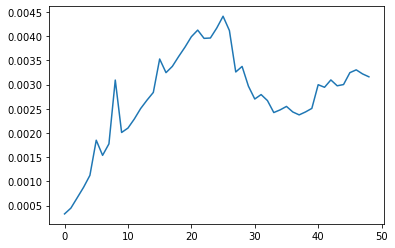

In [894]:
P = np.arange(2000)
T = []

for n in range(0,1000,20):
    naif_eval(1.01, P[:n])
    T.append(time.time())

# this calculates differences between consecutive elements in T[]
plt.plot(np.diff(T,1));

In [851]:
horner_py(.9,P[:70])

9.993734212517824

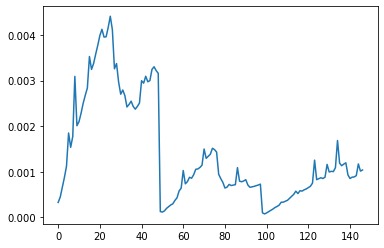

In [896]:
P = np.arange(2000)

for n in range(0,1000,20):
    horner_py(1.1,P[:n])
    T.append(time.time())

ts = np.diff(T,1)
plt.plot(ts[ts<.1][:]);

In [898]:
horner_py(1.1,P), naif_eval(1.1,P)

(1.2134030984085583e+87, 1.2134030984085563e+87)

---

I do sometimes compile Python to C using [Cython](https://cython.org/)
and then comparing speeds between different implementations does make sense.

In [768]:
%%cython

import cython

def horner(double x, list P):
    cdef double val = 0
    for coeff in reversed(P):
        val *= x
        val += coeff
        
    return val

In [85]:
P = [1]*500
horner(.9,P), sum([.9**i * coeff for i, coeff in enumerate(P)])

(9.999999999999995, 9.999999999999993)

In [86]:
%%timeit 
horner(.9,P)

17.9 µs ± 545 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [87]:
%%timeit 
horner_py(.9,P)

30.1 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [65]:
%%timeit 
np.array(P).dot(np.array([.9**i for i in range(len(P))]))

3.99 µs ± 168 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [88]:
%%timeit 
sum ([.9**i * coeff for i, coeff in enumerate(P)])

85.6 µs ± 4.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [92]:
def ev(x,P):
    s = 0 
    for i,c in enumerate(P):
        s += c*x**i
    return s

ev(.9,P), horner(.9,P)

(9.999999999999993, 9.999999999999995)

In [91]:
%%timeit 
ev(.9,P)

85 µs ± 2.59 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [127]:
%%cython 

import cython
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)

def n2b(int x, int b=2):  
    cdef list digits = []
    
    while x > 0:
        digits.append(x % b)
        x //= b
    return list(reversed(digits))


In [124]:
%%cython

import cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)

def n2b(int x, int b=2):  
    cdef np.ndarray digits = np.zeros(20, dtype=int)
    
    cdef int i = 19
    while x > 0:
        digits[i] = x % b
        i -= 1
        x //= b
    return digits[i:]


In [129]:
%%timeit

n2b(167)

386 ns ± 13.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [230]:
%%timeit
n2b(167)

388 ns ± 14.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [228]:
%%timeit

p = num2base(167)

1.22 µs ± 26.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [11]:
# Exo 8



In [222]:
import numpy as np

import matplotlib.pyplot as plt

N = 8
A = 2*np.identity(N)
for i in range(N-1):
    A[i,i+1] = A[i+1,i] = -1
A

array([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])

---

# check for eigenvectors

In [180]:
k = 2
T = np.pi*k*np.arange(1,N+1)/(N+1)
U = np.sin(T)
#this fails sometimes, division by something close to  zero
A.dot(U)/U

array([0.46791111, 0.46791111, 0.46791111, 0.46791111, 0.46791111,
       0.46791111, 0.46791111, 0.46791111])

In [183]:
sum(np.linalg.eigvals(A)), np.linalg.eigvals(A)

(15.999999999999988,
 array([3.87938524, 3.53208889, 3.        , 2.34729636, 1.65270364,
        0.12061476, 0.46791111, 1.        ]))

# Better to 

write a function to generate the matrix $A$

In [4]:
def M(n):
    A = 2*np.identity(n)
    for i in range(n-1):
        A[i,i+1] = A[i+1,i] = -1
    return A


X = np.linspace(0,1,100)

plt.plot(X, 12*X**2+4);
plt.plot(X[2:-2],-100**2*M(100).dot(X**4+ 2*X**2)[2:-2]);

NameError: name 'plt' is not defined

0.0034362595476501016

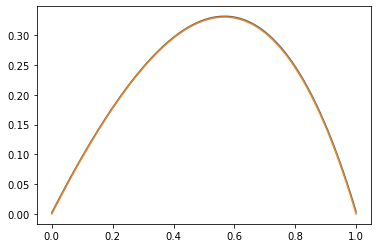

In [230]:

N = 500
# subdivision of the interval
X = np.linspace(0,1,N)
h = (X[1] - X[0])

# -A/h^2 + C
B = M(N)/(h**2) + np.diag(X)
# this is probably more accurate as N**2 has no rounding error
B = M(N)*(N**2) + np.diag(X)

f = (1 + 2*X - X**2)*np.exp(X) + X**2 - X
g = (1-X)*(np.exp(X)-1)

Y = np.linalg.solve(B, f)
plt.plot(X, Y)
plt.plot(X, g);

np.max(np.abs(Y - g))

---

# Jacobi method

In numerical linear algebra, the Jacobi method is an iterative algorithm for determining the solutions of a strictly diagonally dominant system of linear equations. Each diagonal element is solved for, and an approximate value is plugged in. The process is then iterated until it converges. This algorithm is a stripped-down version of the Jacobi transformation method of matrix diagonalization. The method is named after Carl Gustav Jacob Jacobi.

https://en.wikipedia.org/wiki/Jacobi_method

In [232]:
C = np.array([2,1,5,7]).reshape(2,2)

In [32]:
def decompose(C):
    D = np.array([C[i,i] for i in range(C.shape[0])])
    LU = np.copy(C) - np.diag(D)
    return D, LU

V = np.ones(2)
b = np.array([11,13])
D, LU = decompose(C)

In [732]:
for k in range(20):
    #V = (-LU.dot(V) + b)/D
    V = V + (-C.dot(V) + b)/D
C.dot(V)

array([10.99999999, 13.        ])

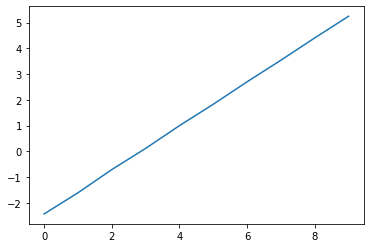

In [42]:
# initialize the matrix
C = np.array([[10., -1., 2., 0.],
              [-1., 11., -1., 3.],
              [2., -1., 10., -1.],
              [0.0, 3., -1., 8.]])
# initialize the RHS vector
b = np.array([6., 25., -11., 15.])
V = np.zeros_like(C[0])

D, LU = decompose(C)

VS = []
for k in range(10):
    V = (-LU.dot(V) + b)/D
    VS.append(V)

E = [np.linalg.norm( b - C.dot(v)) for v in VS]
plt.plot(-np.log(E));

In [38]:
from scipy import stats

         
stats.linregress(np.arange(len(E)),-np.log(E))

LinregressResult(slope=0.854590388387257, intercept=-2.4365624942108233, rvalue=0.9999854699430567, pvalue=1.950023073529421e-19, stderr=0.001628794894121396)

# Eigenvalues

In [50]:
ev, evv = np.linalg.eig(np.linalg.inv(np.diag(D).dot(C)))

array([10., 11., 10.,  8.])

---

## Jacobi applied to the exo 8

In [28]:
N = 200
X = np.linspace(0,1,N)

B = M(N)*(N**2) + np.diag(X)
# target function
b = (1 + 2*X - X**2)*np.exp(X) + X**2 - X 
# exact solution
g = (1-X)*(np.exp(X)-1)
# initial guess
V = np.ones(N)

# could use
# D = 2*N**2 - X

D = np.array([B[i,i] for i in range(N)])

## Iteration loop

In [29]:
#%%timeit
E = []
for k in range(4000):
    #V = (-LU.dot(V) + b)/D
    V = V + (-B.dot(V) + b)/D
    E.append(np.linalg.norm(V - g,np.inf))
    

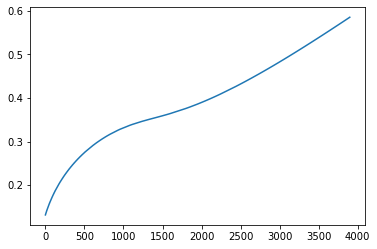

In [30]:
plt.plot(-np.log(np.array(E[100:])))

(0.008589502825312118, 0.008589502825312118)

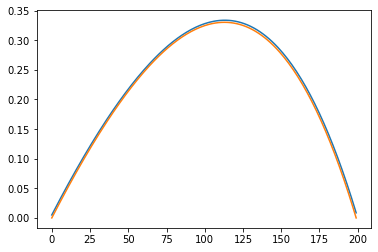

In [367]:
plt.plot(V);
plt.plot(g );

np.max(np.abs(V - g)), np.linalg.norm(V-g, np.inf)

In [363]:
#%%timeit
K = N**2*np.array([1,-2,1])

for k in range(500000):
    #trick to avoid matrix multiplication
    V = V + ( np.convolve(V, K, mode='same')- X*V + b)/D
    

---

# Convergence

- easy case $C$ symmetric positive definite
- $(L + U)/D$ has a dominant eigenvalue

In [52]:
C = np.array([2,1,1,1]).reshape(2,2)

In [56]:
D = np.array([C[i,i] for i in range(C.shape[0])])

In [66]:
C.dot([0,1])

array([1, 1])

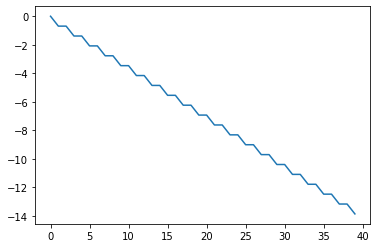

In [91]:
C = np.array([2,1,1,1]).reshape(2,2)
D = np.array([C[i,i] for i in range(C.shape[0])])
V = np.ones(2)
b = np.ones(2)

E = []
for k in range(40):
    #V = (-LU.dot(V) + b)/D
    V = V + (-C.dot(V) + b)/D
    E.append(np.linalg.norm(V - [0,1]))
plt.plot(np.log(E));

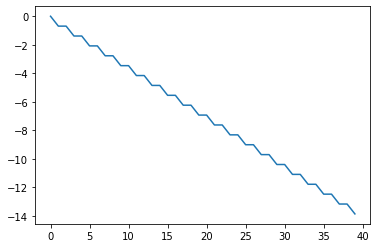

In [92]:
plt.plot(np.log(E));

In [93]:
DC = np.diag(D)
ee, vv = np.linalg.eig((C-DC)/D)

array([[2, 0],
       [0, 1]])